In [4]:
!pip install kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayasquallihoussaini","key":"2a0a06840c3d4f417d08028de774744f"}'}

In [9]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [10]:
#Import dataset
!kaggle datasets download -d mkashifn/nbaiot-dataset

Dataset URL: https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset
License(s): unknown
100% 1.75G/1.75G [00:25<00:00, 47.6MB/s]
100% 1.75G/1.75G [00:25<00:00, 74.8MB/s]


In [12]:
!unzip nbaiot-dataset.zip -d content

Archive:  nbaiot-dataset.zip
  inflating: content/1.benign.csv    
  inflating: content/1.gafgyt.combo.csv  
  inflating: content/1.gafgyt.junk.csv  
  inflating: content/1.gafgyt.scan.csv  
  inflating: content/1.gafgyt.tcp.csv  
  inflating: content/1.gafgyt.udp.csv  
  inflating: content/1.mirai.ack.csv  
  inflating: content/1.mirai.scan.csv  
  inflating: content/1.mirai.syn.csv  
  inflating: content/1.mirai.udp.csv  
  inflating: content/1.mirai.udpplain.csv  
  inflating: content/2.benign.csv    
  inflating: content/2.gafgyt.combo.csv  
  inflating: content/2.gafgyt.junk.csv  
  inflating: content/2.gafgyt.scan.csv  
  inflating: content/2.gafgyt.tcp.csv  
  inflating: content/2.gafgyt.udp.csv  
  inflating: content/2.mirai.ack.csv  
  inflating: content/2.mirai.scan.csv  
  inflating: content/2.mirai.syn.csv  
  inflating: content/2.mirai.udp.csv  
  inflating: content/2.mirai.udpplain.csv  
  inflating: content/3.benign.csv    
  inflating: content/3.gafgyt.combo.csv  
  inf

In [19]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sea
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, make_scorer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [13]:
#Testing for only one device (2 for example)
benign = pd.read_csv('content/2.benign.csv')
combo = pd.read_csv('content/2.gafgyt.combo.csv')
junk = pd.read_csv('content/2.gafgyt.junk.csv')
g_scan = pd.read_csv('content/2.gafgyt.scan.csv')
g_tcp = pd.read_csv('content/2.gafgyt.tcp.csv')
g_udp = pd.read_csv('content/2.gafgyt.udp.csv')
m_scan = pd.read_csv('content/2.mirai.scan.csv')
m_ack = pd.read_csv('content/2.mirai.ack.csv')
m_syn = pd.read_csv('content/2.mirai.syn.csv')
m_udp = pd.read_csv('content/2.mirai.udp.csv')
m_udpplain = pd.read_csv('content/2.mirai.udpplain.csv')

In [14]:
# Attack Labels
benign['type'] = 'benign'
combo['type'] = 'gafgyt.combo'
junk['type'] = 'gafgyt.junk'
g_scan['type'] = 'gafgyt.scan'
g_tcp['type'] = 'gafgyt.tcp'
g_udp['type'] = 'gafgyt.udp'
m_scan['type'] = 'mirai.scan'
m_ack['type'] = 'mirai.ack'
m_syn['type'] = 'mirai.syn'
m_udp['type'] = 'mirai.udp'
m_udpplain['type'] = 'mirai.udpplain'

In [15]:
df = pd.concat([benign, combo, junk, g_scan, g_tcp, g_udp, m_scan, m_ack, m_syn,m_udp, m_udpplain], axis=0, ignore_index=True, sort=False)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 835876 entries, 0 to 835875
Columns: 116 entries, MI_dir_L5_weight to type
dtypes: float64(115), object(1)
memory usage: 739.8+ MB


In [17]:
df["type"].value_counts()

,count
type,
mirai.udp,151481
mirai.syn,116807
mirai.ack,113285
gafgyt.udp,104791
gafgyt.tcp,95021
mirai.udpplain,87368
gafgyt.combo,53012
mirai.scan,43192
gafgyt.junk,30312


<Axes: title={'center': 'Class Distribution (Testing for Device 2: Thermostat)'}, xlabel='count', ylabel='type'>

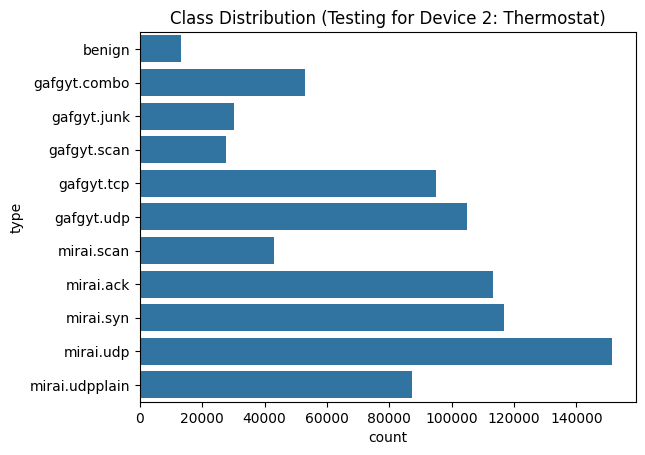

In [20]:
plt.title("Class Distribution (Testing for Device 2: Thermostat)")
sea.countplot(df["type"])

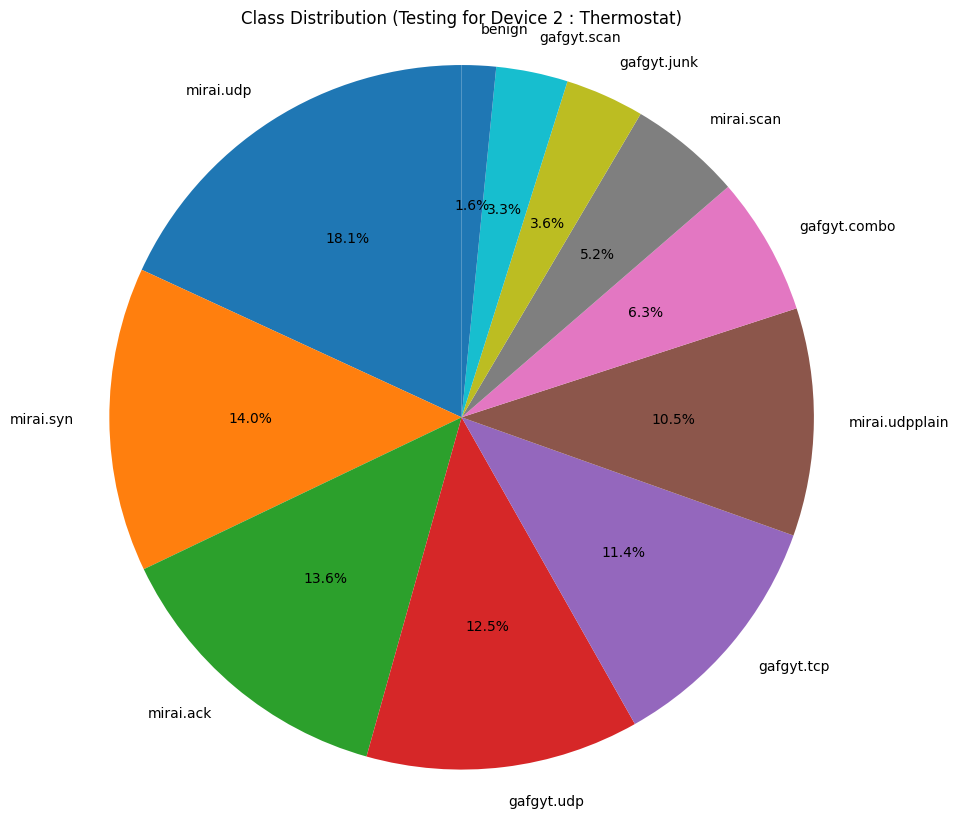

In [21]:
plt.figure(figsize=(10, 10))
plt.title("Class Distribution (Testing for Device 2 : Thermostat)")
df["type"].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.ylabel('')
plt.axis('equal')
plt.show()

# PCA

Explained variance ratio (first 10): [0.36349391 0.19920878 0.1127247  0.0636909  0.0510635  0.03296899
 0.02924453 0.02599165 0.01628042 0.01562933]
Cumulative variance explained: 1.0
PCA components kept: 115


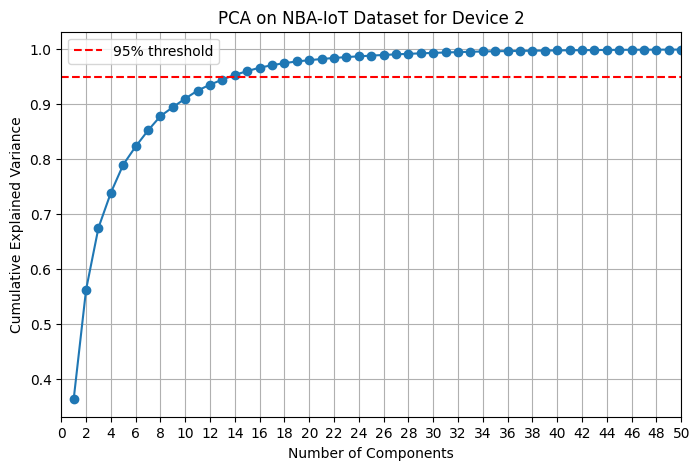

In [22]:
y = df['type']
x = df.drop(columns=['type'])

#Scale features
scaler = StandardScaler()
scaler.fit(x) # Fit only on numerical features
X = scaler.transform(x) # Transform only numerical features

pca = PCA(n_components=None, random_state=0)
X_pca = pca.fit_transform(X)

print("Explained variance ratio (first 10):", pca.explained_variance_ratio_[:10])
print("Cumulative variance explained:", pca.explained_variance_ratio_.sum())
print("PCA components kept:", X_pca.shape[1])

df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])], index=df.index)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1),
         cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% threshold")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA on NBA-IoT Dataset for Device 2")
plt.xticks(range(0, len(cumulative_variance)+1, 2))

plt.xlim([0, 50])
plt.grid()
plt.legend()
plt.show()

In [23]:
# Smallest k such that C(k) >= 95%
n_components = next(i for i, cv in enumerate(cumulative_variance, 1) if cv >= 0.95)
print("Optimal number of components (95% variance):", n_components)




Optimal number of components (95% variance): 14


In [24]:
pca_opt = PCA(n_components=n_components)
X_reduced = pca_opt.fit_transform(X)

print("Reduced shape:", X_reduced.shape)


Reduced shape: (835876, 14)


## TSNE

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


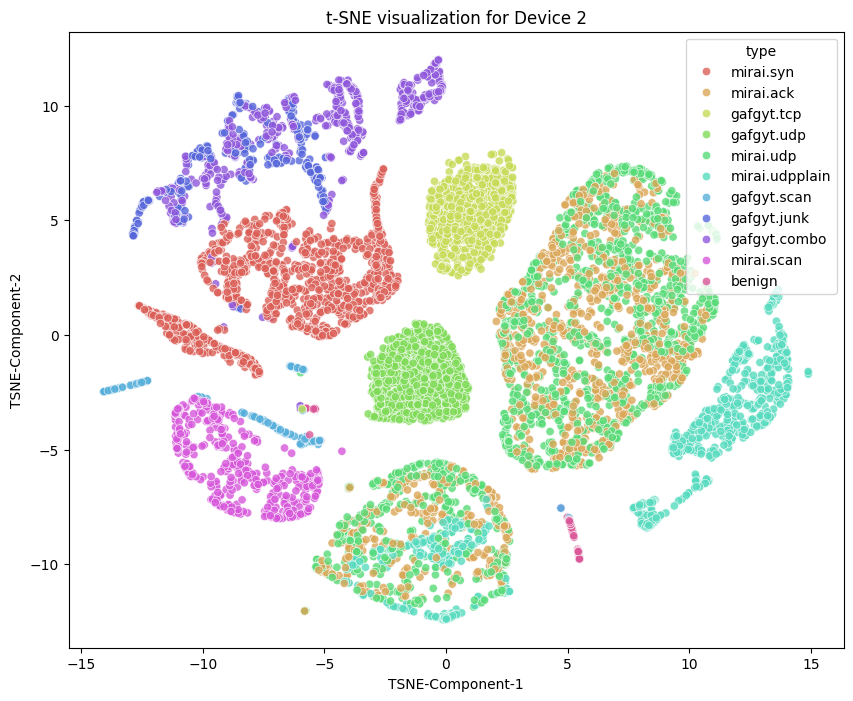

In [25]:
from sklearn.manifold import TSNE
import seaborn as sns

# Use the combined dataframe for device 6
# Assuming 'df' contains the data for device 6 as loaded previously
X_device = df.drop(columns=['type'])
y_device = df['type']

# Scale features for the single device data
scaler_device = StandardScaler()
X_scaled_device = scaler_device.fit_transform(X_device)

# Select a subset of the data for t-SNE
# Adjust the fraction or number of samples as needed based on computational resources
subset_size = 10000
if X_scaled_device.shape[0] > subset_size:
    np.random.seed(42) # for reproducibility
    subset_indices = np.random.choice(X_scaled_device.shape[0], subset_size, replace=False)
    X_subset = X_scaled_device[subset_indices]
    y_subset = y_device[subset_indices]
else:
    X_subset = X_scaled_device
    y_subset = y_device


# Perform t-SNE
# Adjust perplexity and n_iter based on your data and desired visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_subset)

# Create a DataFrame for plotting
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE-Component-1', 'TSNE-Component-2'])
tsne_df['type'] = y_subset.reset_index(drop=True) # Ensure index aligns

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="TSNE-Component-1", y="TSNE-Component-2",
    hue="type",
    palette=sns.color_palette("hls", len(y_subset.unique())),
    data=tsne_df,
    legend="full",
    alpha=0.8
)
plt.title('t-SNE visualization for Device 2')
plt.show()

# Random Forest Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42
)

# Random Forest
rf = RandomForestClassifier(max_depth=10, n_estimators=200, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluation
#Accuracy Metric
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
#F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
#Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.9446728584360532
F1 Score: 0.9440925981836547

Classification Report:
                 precision    recall  f1-score   support

        benign       0.99      1.00      1.00      3886
  gafgyt.combo       0.87      0.92      0.90     15869
   gafgyt.junk       0.86      0.76      0.80      9102
   gafgyt.scan       1.00      1.00      1.00      8129
    gafgyt.tcp       1.00      1.00      1.00     28593
    gafgyt.udp       1.00      1.00      1.00     31448
     mirai.ack       0.98      0.79      0.88     34249
    mirai.scan       1.00      1.00      1.00     12860
     mirai.syn       1.00      1.00      1.00     35068
     mirai.udp       0.85      0.96      0.90     45362
mirai.udpplain       0.92      0.94      0.93     26197

      accuracy                           0.94    250763
     macro avg       0.95      0.94      0.95    250763
  weighted avg       0.95      0.94      0.94    250763



In [27]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Train F1:", f1_score(y_train, y_pred_train, average='weighted'))
print("Test F1:", f1_score(y_test, y_pred_test, average='weighted'))

Train Accuracy: 0.9467555839641232
Test Accuracy: 0.9446728584360532
Train F1: 0.9462556693139375
Test F1: 0.9440925981836547


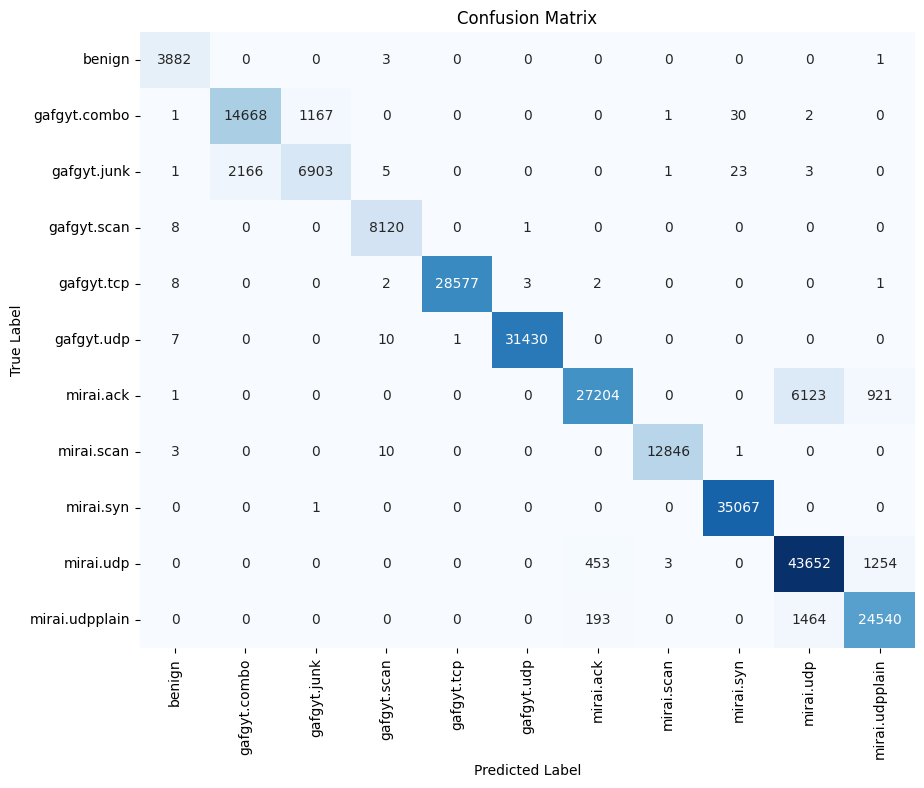

In [28]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sea.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## Stratified Cross Validation

In [ ]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='weighted')
accuracy_scorer = make_scorer(accuracy_score)
# F1 Score
f1_scores = cross_val_score(rf, X, y, cv=skf, scoring=f1_scorer)
print("F1 Scores for each fold:", f1_scores)
print("Mean F1:", np.mean(f1_scores))
print("Std F1:", np.std(f1_scores))

# Accuracy
accuracy_scores = cross_val_score(rf, X, y, cv=skf, scoring=accuracy_scorer)
print("Accuracy for each fold:", accuracy_scores)
print("Mean Accuracy:", np.mean(accuracy_scores))
print("Std Accuracy:", np.std(accuracy_scores))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:978: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 140, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_response.py", line 207, in _get_response_values
    raise ValueError(
ValueError: pos_label=1 is not a valid label: It should be one of ['benign' 'gafgyt.combo' 'gafgyt.junk' 'gafgyt.scan' 'gafgyt.tcp'
 'gafgyt.udp'